# Default of Credit Card Holders Prediction

In [143]:
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import eli5
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    make_scorer,
    f1_score,
    plot_confusion_matrix,
)
from sklearn.feature_selection import RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import loguniform
from scipy.stats import lognorm, loguniform, randint
import shap

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

## 1. Understanding the problem <a name="1"></a>
<hr>

**Source**: [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) 

**Goal**: To estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data.

In [27]:
credit_data = pd.read_csv("UCI_Credit_Card.csv")
credit_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [28]:
credit_data.shape

(30000, 25)

By glancing the data, the data has 30000 examples which is a **moderate size** and 25 columns which is a **small dimension**. We are trying to build a model which can classify whether a credit card client will default or not on based on some demographic factors, credit data, history of payment, and bill statements of credit in Taiwan from April 2005 to September 2005. Therefore, it is a **classification** problem. 

The column `default.payment.next.month` is the response variable which has value 1(default) and 0(not default). Therefore, it is a **binary classification** problem. 

The class of the target values might have **imbalance problem** because I think most of the credit card holders have the ability to pay their bills. However, we care about clients who will default to pay their bill. So checking class imbalance is a good start.

## 2. Data splitting <a name="2"></a>
<hr>

In [29]:
train_df, test_df = train_test_split(credit_data, test_size=0.2, random_state=123)

## 3. EDA <a name="3"></a>
<hr>

In [87]:
X_train, y_train = train_df.drop(columns=["ID", "default.payment.next.month"]), train_df["default.payment.next.month"]
X_test, y_test = test_df.drop(columns=["ID", "default.payment.next.month"]), test_df["default.payment.next.month"]

In [88]:
y_train.value_counts(normalize=True)

0    0.777833
1    0.222167
Name: default.payment.next.month, dtype: float64

The summary statistics of the **proportion of target classes** are 77.8% vs 22.2% which means the classes are **imbalanced**.

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19682 to 19966
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_0      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PA

The summary statistics of **null value counts** shows there are no missing values for all columns. So we don't need to worry about imputation for each column. Also, all columns are **numerically encoded**, but we can tell that columns as `SEX`, `EDUCATION`, `MARRIAGE` are more likely to be categorical features.

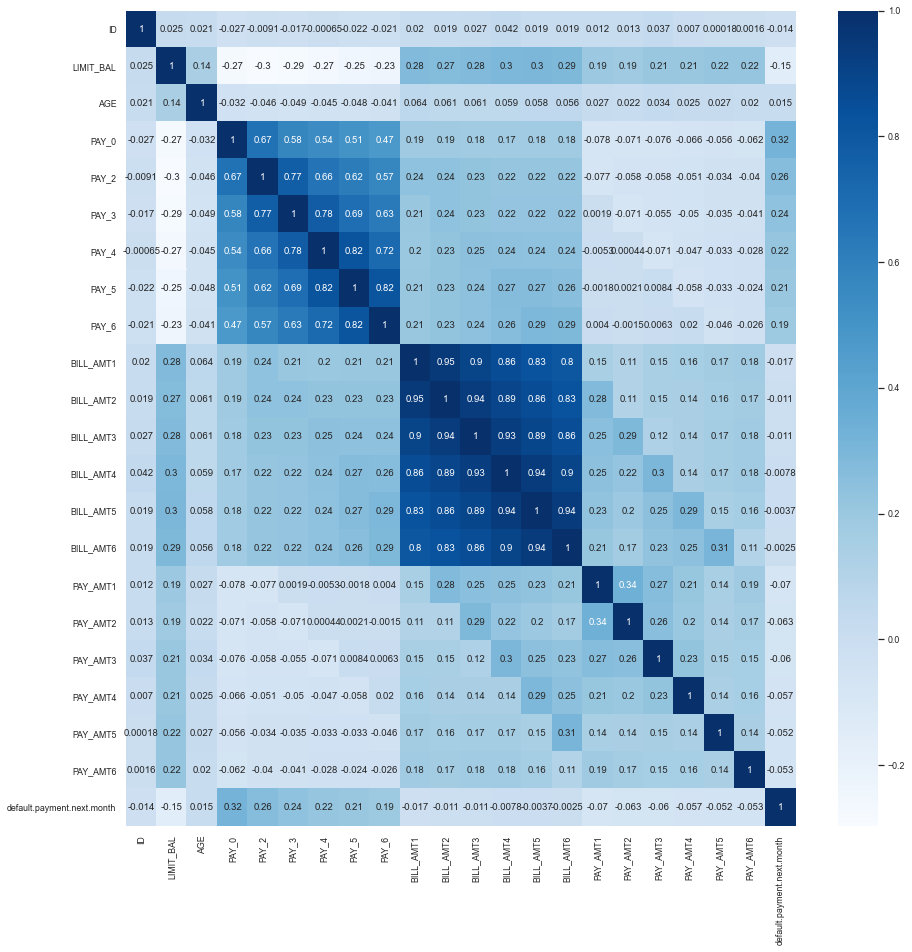

In [33]:
cor = train_df.drop(columns=["SEX", "EDUCATION", "MARRIAGE"]).corr();
plt.figure(figsize=(15,15))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

Here is a **correlation plot** between all numeric variables, PAY status variables and target column. We can check the association between each variable and if co-linearity exists.

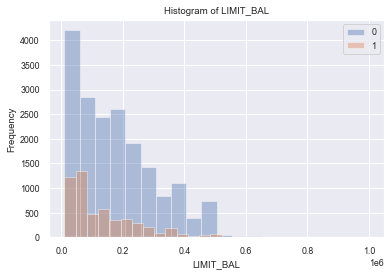

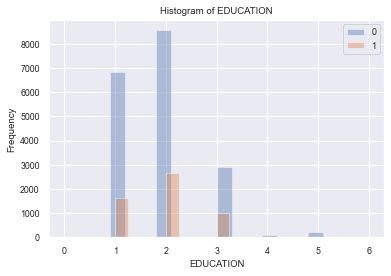

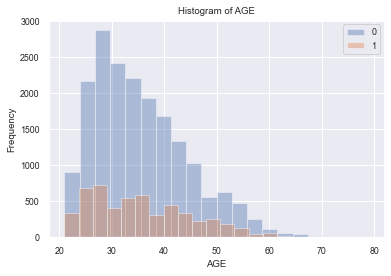

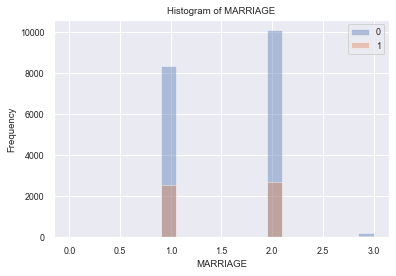

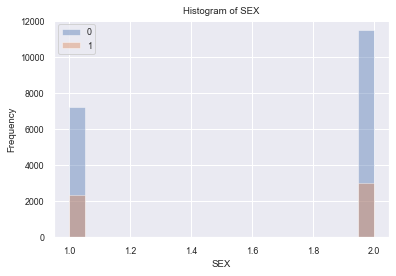

In [34]:
explorative_features = ["LIMIT_BAL", "EDUCATION", "AGE", "MARRIAGE", "SEX"]
for feat in explorative_features:
    ax = train_df.groupby("default.payment.next.month")[feat].plot.hist(bins=20, alpha=0.4, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

Here are **histogram charts** for `LIMIT_BAL`, `EDUCATION`, `AGE`, `MARRIAGE` and `SEX` across two classes of the targets.

In [35]:
scoring_metrics = ["f1_macro", "roc_auc", "average_precision"]

**Interesting observations:**
1. There are -2 and 0 for `PAY_*` columns which are not in the description.
2. Education has value 0 which is not in the description.

[Link to the clarrification](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608)

### **Summary**

The class distribution of the target value is 77.8% vs 22.2% and the positive class is `default.payment.next.month` with 1. Therefore, false negative will bring more money loss to credit card company. However, precision is also important because it might decrease customer loyalty if a non-default client is classified as default client. Therefore We should use macro-average f1 score here as scoring metric instead of accuracy. Also, it's good to check with ROC-AUC and AP for the goodness of the model compared to a random guesser.

**From correlation plot:**

I dropped some categorical features in the correlation plot but kept the pay status since the number has a ranking such as how many months the clients are not able to pay the bill and the negative values indicates no risk of having default since -2 means no consumption on the card and -1 means they pay the bill on time. Therefore, the correlation between them and target has meaning.

From the correlation plot, we can see there are strong correlation between all the pay status columns and bill amount columns. Therefore, it might have co-linearity issues. Also, the pay status has a relatively high correlation with the target which means it might be a strong predictor for this problem. Limit balance has around 0.3 correlation with bill amounts which means clients have higher limit will have a bill with larger amount.

**From histograms:**
1. The counts of people who have higher credits(>4000_000 NTD) are much less than those who have lower credits(<100_000 NTD). 
2. Majority of people who applied for credit cards in Taiwan from April 2015 to September 2015 graduated from a university or graduate school. 
3. Those who are 30's are more likely to apply for credit cards compared to those who are under 25 and over 40.
4. People who is single are more likely to apply for a credit card than those who married but there is no much difference among the default clients.

Since there is class imbalanced issue, the frequencies of class 1 among all features are less than those of class 0. But we can see that the distribution of limit balance of default clients are more right-skewed than non-default clients. Also, the correlation between target and limit balance is -0.15, so it might be a good feature to keep in the model. But for other features, I don't see too much distinction in distribution between different classes.

## 4. Feature engineering <a name="4"></a>
<hr> 

In [90]:
X_train_new = X_train.copy()
X_train_new["PAY_PORTION_1"] = (X_train_new["BILL_AMT1"] - X_train_new["PAY_AMT1"]) / X_train_new["LIMIT_BAL"]
X_train_new["PAY_PORTION_2"] = (X_train_new["BILL_AMT2"] - X_train_new["PAY_AMT2"]) / X_train_new["LIMIT_BAL"]
X_train_new["PAY_PORTION_3"] = (X_train_new["BILL_AMT3"] - X_train_new["PAY_AMT3"]) / X_train_new["LIMIT_BAL"]
X_train_new["PAY_PORTION_4"] = (X_train_new["BILL_AMT4"] - X_train_new["PAY_AMT4"]) / X_train_new["LIMIT_BAL"]
X_train_new["PAY_PORTION_5"] = (X_train_new["BILL_AMT5"] - X_train_new["PAY_AMT5"]) / X_train_new["LIMIT_BAL"]
X_train_new["PAY_PORTION_6"] = (X_train_new["BILL_AMT6"] - X_train_new["PAY_AMT6"]) / train_df["LIMIT_BAL"]

X_train_new.loc[~((X_train_new.AGE <= 35) & (X_train_new.LIMIT_BAL >= 400000)), "POTENTIAL_RISK"] = 0
X_train_new.loc[(X_train_new.AGE <= 35) & (X_train_new.LIMIT_BAL >= 400000), "POTENTIAL_RISK"] = 1

1. PAY_PORTION_* means the proportion of the amount owed to bank each month over the credit card limit.

2. POTENTIAL_RISK is a binary feature indicating whether a person is less than 35 but having a high credit limit over 400000 NTD.

## 5. Preprocessing and transformations <a name="5"></a>
<hr>


In [92]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [96]:
X_train_new.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'PAY_PORTION_1', 'PAY_PORTION_2', 'PAY_PORTION_3', 'PAY_PORTION_4',
       'PAY_PORTION_5', 'PAY_PORTION_6', 'POTENTIAL_RISK'],
      dtype='object')

In [95]:
binary_features = ["SEX"]
binary_features_new = ["SEX", "POTENTIAL_RISK"]

categorical_features = [
    "MARRIAGE",
    "EDUCATION",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
]

numeric_features = list(
    set(X_train.columns) - set(categorical_features) - set(binary_features)
)

numeric_features_new = [
    "PAY_PORTION_1",
    "PAY_PORTION_2",
    "PAY_PORTION_3",
    "PAY_PORTION_4",
    "PAY_PORTION_5",
    "PAY_PORTION_6",
] + numeric_features

In [167]:
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)
binary_transformer = make_pipeline(OneHotEncoder(drop="if_binary"))

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['PAY_AMT1', 'AGE', 'PAY_AMT6', 'PAY_AMT2',
                                  'PAY_AMT5', 'BILL_AMT3', 'PAY_AMT4',
                                  'BILL_AMT4', 'LIMIT_BAL', 'BILL_AMT1',
                                  'BILL_AMT5', 'BILL_AMT2', 'PAY_AMT3',
                                  'BILL_AMT6']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['SEX']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                          

In [99]:
preprocessor_new = make_column_transformer(
    (numeric_transformer, numeric_features_new),
    (binary_transformer, binary_features_new),
    (categorical_transformer, categorical_features),
)
preprocessor_new.fit(X_train_new, y_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['PAY_PORTION_1', 'PAY_PORTION_2',
                                  'PAY_PORTION_3', 'PAY_PORTION_4',
                                  'PAY_PORTION_5', 'PAY_PORTION_6', 'PAY_AMT1',
                                  'AGE', 'PAY_AMT6', 'PAY_AMT2', 'PAY_AMT5',
                                  'BILL_AMT3', 'PAY_AMT4', 'BILL_AMT4',
                                  'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT5',
                                  'BILL_AMT2', 'PAY_AMT3', 'BILL_AMT6']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['SEX', 'POTENTIAL_RISK']),
                                ('pipelin

I dropped `ID` because `ID` will be an exact match of target, so we should not keep it in the model.

Since `BILL_AMT*` and `PAY_AMT*` columns are bill amounts and amount of previous payments, they are all continuous and uncountable as well as `AGE`, `LIMIT_BAL`, we should treat them as numeric features. The new features I added in, `PAY_PORTION_*` means the proportion of the amount owed to bank each month over the credit card limit which means it is also uncountable. Therefore, they are also numeric.

The new feature `POTENTIAL_RISK` is a binary feature indicating whether a person is less than 35 but having a high credit limit over 400000 NTD.

`MARRIAGE`, `EDUCATION` and `PAY_*` are categorical features, because the number indicates the marital status, education level and pay status which are all countable. `PAY_*` has values -2, -1, 0 which mean no consumption, paid in full and the use of revolving credit. I think there's no underlying order of these three categories which is why I treated `PAY_*` as categorical features.

## 6. Baseline model <a name="6"></a>
<hr>

In [122]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [123]:
results = {}
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics)
pd.DataFrame(results)

,Dummy
fit_time,0.002 (+/- 0.000)
score_time,0.005 (+/- 0.001)
test_f1_macro,0.502 (+/- 0.007)
train_f1_macro,0.500 (+/- 0.003)
test_roc_auc,0.503 (+/- 0.011)
train_roc_auc,0.503 (+/- 0.002)
test_average_precision,0.224 (+/- 0.004)
train_average_precision,0.223 (+/- 0.001)


## 7. Linear models <a name="7"></a>
<hr>

In [124]:
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=2000, class_weight="balanced", random_state=123),
)

results["LR+class_weight"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

In [125]:
pipe_lr_new = make_pipeline(
    preprocessor_new,
    LogisticRegression(max_iter=2000, class_weight="balanced", random_state=123),
)

results["LR+class_weight+new"] = mean_std_cross_val_scores(
    pipe_lr_new, X_train_new, y_train, return_train_score=True, scoring=scoring_metrics
)

,Dummy,LR+class_weight,LR+class_weight+new
fit_time,0.002 (+/- 0.000),0.668 (+/- 0.070),0.853 (+/- 0.126)
score_time,0.005 (+/- 0.001),0.031 (+/- 0.002),0.038 (+/- 0.011)
test_f1_macro,0.502 (+/- 0.007),0.692 (+/- 0.009),0.692 (+/- 0.009)
train_f1_macro,0.500 (+/- 0.003),0.695 (+/- 0.003),0.696 (+/- 0.003)
test_roc_auc,0.503 (+/- 0.011),0.768 (+/- 0.010),0.769 (+/- 0.010)
train_roc_auc,0.503 (+/- 0.002),0.774 (+/- 0.003),0.775 (+/- 0.003)
test_average_precision,0.224 (+/- 0.004),0.540 (+/- 0.026),0.538 (+/- 0.025)
train_average_precision,0.223 (+/- 0.001),0.550 (+/- 0.007),0.548 (+/- 0.007)


We can see that logistic regression performs better than the dummy classifier. The new features does not improve the linear model performance. But we can try it on SMOTE to see how SMOTE differs from `class_weight=balanced` here.

In [126]:
pipe_smote_lr = make_imb_pipeline(
    preprocessor,
    SMOTE(),
    LogisticRegression(max_iter=2000, random_state=123),
)
results["LR+smote"] = mean_std_cross_val_scores(
    pipe_smote_lr, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

In [127]:
pipe_smote_lr_new = make_imb_pipeline(
    preprocessor_new,
    SMOTE(),
    LogisticRegression(max_iter=2000, random_state=123),
)
results["LR+SMOTE+new"] = mean_std_cross_val_scores(
    pipe_smote_lr_new, X_train_new, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results)

,Dummy,LR+class_weight,LR+class_weight+new,LR+smote,LR+SMOTE+new
fit_time,0.002 (+/- 0.000),0.668 (+/- 0.070),0.853 (+/- 0.126),3.557 (+/- 0.196),3.929 (+/- 0.133)
score_time,0.005 (+/- 0.001),0.031 (+/- 0.002),0.038 (+/- 0.011),0.040 (+/- 0.002),0.044 (+/- 0.002)
test_f1_macro,0.502 (+/- 0.007),0.692 (+/- 0.009),0.692 (+/- 0.009),0.689 (+/- 0.010),0.690 (+/- 0.011)
train_f1_macro,0.500 (+/- 0.003),0.695 (+/- 0.003),0.696 (+/- 0.003),0.693 (+/- 0.003),0.694 (+/- 0.003)
test_roc_auc,0.503 (+/- 0.011),0.768 (+/- 0.010),0.769 (+/- 0.010),0.767 (+/- 0.011),0.767 (+/- 0.012)
train_roc_auc,0.503 (+/- 0.002),0.774 (+/- 0.003),0.775 (+/- 0.003),0.773 (+/- 0.003),0.775 (+/- 0.002)
test_average_precision,0.224 (+/- 0.004),0.540 (+/- 0.026),0.538 (+/- 0.025),0.538 (+/- 0.027),0.537 (+/- 0.025)
train_average_precision,0.223 (+/- 0.001),0.550 (+/- 0.007),0.548 (+/- 0.007),0.550 (+/- 0.007),0.548 (+/- 0.006)


`SMOTE` performs worse than `class_weight=balanced`. Based on Oscam's Razor, we are going to abandon the new features and keep the model simple. Then, we perform hyperparameter tunning on logistic regression with original `X_train`.

In [128]:
param_grid = {
    "logisticregression__C": loguniform(1e-3, 1e3),
}

random_search_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_grid,
    return_train_score=True,
    verbose=1,
    n_iter=30,
    n_jobs=-1,
    scoring="f1_macro",
    random_state=123
)
random_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.4min finished


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['PAY_AMT1',
                                                                                'AGE',
                                                                                'PAY_AMT6',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT5',
                                                                                'BILL_AMT3',
                                                             

In [129]:
results["LR+Optimized"] = mean_std_cross_val_scores(
    random_search_lr.best_estimator_,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metrics,
)
pd.DataFrame(results)

,Dummy,LR+class_weight,LR+class_weight+new,LR+smote,LR+SMOTE+new,LR+Optimized
fit_time,0.002 (+/- 0.000),0.668 (+/- 0.070),0.853 (+/- 0.126),3.557 (+/- 0.196),3.929 (+/- 0.133),0.410 (+/- 0.057)
score_time,0.005 (+/- 0.001),0.031 (+/- 0.002),0.038 (+/- 0.011),0.040 (+/- 0.002),0.044 (+/- 0.002),0.031 (+/- 0.004)
test_f1_macro,0.502 (+/- 0.007),0.692 (+/- 0.009),0.692 (+/- 0.009),0.689 (+/- 0.010),0.690 (+/- 0.011),0.692 (+/- 0.009)
train_f1_macro,0.500 (+/- 0.003),0.695 (+/- 0.003),0.696 (+/- 0.003),0.693 (+/- 0.003),0.694 (+/- 0.003),0.695 (+/- 0.003)
test_roc_auc,0.503 (+/- 0.011),0.768 (+/- 0.010),0.769 (+/- 0.010),0.767 (+/- 0.011),0.767 (+/- 0.012),0.768 (+/- 0.010)
train_roc_auc,0.503 (+/- 0.002),0.774 (+/- 0.003),0.775 (+/- 0.003),0.773 (+/- 0.003),0.775 (+/- 0.002),0.773 (+/- 0.002)
test_average_precision,0.224 (+/- 0.004),0.540 (+/- 0.026),0.538 (+/- 0.025),0.538 (+/- 0.027),0.537 (+/- 0.025),0.540 (+/- 0.025)
train_average_precision,0.223 (+/- 0.001),0.550 (+/- 0.007),0.548 (+/- 0.007),0.550 (+/- 0.007),0.548 (+/- 0.006),0.547 (+/- 0.007)


In [130]:
print(f"The best regularization hyperparameter is {random_search_lr.best_params_}")

The best regularization hyperparameter is {'logisticregression__C': 0.14816032900504092}


**Summary**: 
1. Logistic regression is better than dummy classifier.
2. To deal with class imbalance, `class_weight=balanced` and oversampling method, `SMOTE` both gave similar validation macro-f1. So I will pick `class_weight='balanced'` since it fits the model with less time than `SMOTE`.
3. The validation macro-f1 of logistic regression after hyperparamter tunning of C is 0.692 with 0.009 standard deviation which means the macro-f1 score is reliable.
4. The validation macro-f1 does not improve after hyperparameter tunning so I will pick `C=1` which is the default option of logistic regression because it gives a lower complexity model compared to `C=0.1`.
5. It seems like all models are underfitting since the gap between train_f1_macro and test_f1_macro is pretty small. Therefore, probably non-linear models will perform better on this task.

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={accuracy:4,quality:2,reasoning:4}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. 
2. Summarize your results. Can you beat logistic regression? 

In [131]:
algorithm_selection = {}
algorithm_selection["LR+class_weight"] = results["LR+class_weight"]
algorithm_selection["Dummy"] = results["Dummy"]

In [133]:
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
class_ratio

3.50112528132033

In [136]:
pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(class_weight="balanced", random_state=123)
)
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(scale_pos_weight=class_ratio, random_state=123)
)
pipe_lgbm = make_pipeline(
    preprocessor, LGBMClassifier(scale_pos_weight=class_ratio, random_state=123)
)
pipe_nb = make_pipeline(preprocessor, GaussianNB())
pipe_svc = make_pipeline(preprocessor, SVC())

classifiers = {
    "Random Forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LGBM": pipe_lgbm,
    "Naive Bayes": pipe_nb,
    "SVM_RBF": pipe_svc,
}

In [137]:
for name, model in classifiers.items():
    algorithm_selection[name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        return_train_score=True,
        scoring=scoring_metrics
    )

In [138]:
pd.DataFrame(algorithm_selection)

,LR+class_weight,Dummy,Random Forest,XGBoost,LGBM,Naive Bayes,SVM_RBF
fit_time,0.668 (+/- 0.070),0.002 (+/- 0.000),2.742 (+/- 0.135),1.460 (+/- 0.052),0.240 (+/- 0.032),0.064 (+/- 0.008),29.360 (+/- 2.100)
score_time,0.031 (+/- 0.002),0.005 (+/- 0.001),0.190 (+/- 0.010),0.052 (+/- 0.003),0.043 (+/- 0.002),0.036 (+/- 0.005),6.460 (+/- 0.156)
test_f1_macro,0.692 (+/- 0.009),0.502 (+/- 0.007),0.668 (+/- 0.013),0.678 (+/- 0.010),0.685 (+/- 0.008),0.597 (+/- 0.024),0.667 (+/- 0.013)
train_f1_macro,0.695 (+/- 0.003),0.500 (+/- 0.003),0.999 (+/- 0.000),0.847 (+/- 0.005),0.763 (+/- 0.004),0.597 (+/- 0.024),0.678 (+/- 0.002)
test_roc_auc,0.768 (+/- 0.010),0.503 (+/- 0.011),0.759 (+/- 0.009),0.756 (+/- 0.013),0.778 (+/- 0.010),0.739 (+/- 0.014),0.729 (+/- 0.007)
train_roc_auc,0.774 (+/- 0.003),0.503 (+/- 0.002),1.000 (+/- 0.000),0.956 (+/- 0.002),0.893 (+/- 0.003),0.741 (+/- 0.003),0.828 (+/- 0.003)
test_average_precision,0.540 (+/- 0.026),0.224 (+/- 0.004),0.534 (+/- 0.023),0.530 (+/- 0.023),0.553 (+/- 0.029),0.494 (+/- 0.018),0.518 (+/- 0.020)
train_average_precision,0.550 (+/- 0.007),0.223 (+/- 0.001),1.000 (+/- 0.000),0.865 (+/- 0.006),0.722 (+/- 0.005),0.495 (+/- 0.004),0.629 (+/- 0.007)


All tree-based models, SVM and Naive Bayes are non-linear models. Since our features are highly correlated, Naive Bayes performs really bad here. SVM takes a long time to fit and is underfitting here. So we are going to abandon Naive Bayes and SVM.

In [139]:
del classifiers["Naive Bayes"]
del classifiers["SVM_RBF"]

In [142]:
stacking_model = StackingClassifier(
    list(classifiers.items()), final_estimator=LogisticRegression(random_state=123)
)
algorithm_selection["Stacking"] = mean_std_cross_val_scores(
    stacking_model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(algorithm_selection)

,LR+class_weight,Dummy,Random Forest,XGBoost,LGBM,Naive Bayes,SVM_RBF,Stacking
fit_time,0.668 (+/- 0.070),0.002 (+/- 0.000),2.742 (+/- 0.135),1.460 (+/- 0.052),0.240 (+/- 0.032),0.064 (+/- 0.008),29.360 (+/- 2.100),22.004 (+/- 1.601)
score_time,0.031 (+/- 0.002),0.005 (+/- 0.001),0.190 (+/- 0.010),0.052 (+/- 0.003),0.043 (+/- 0.002),0.036 (+/- 0.005),6.460 (+/- 0.156),0.370 (+/- 0.011)
test_f1_macro,0.692 (+/- 0.009),0.502 (+/- 0.007),0.668 (+/- 0.013),0.678 (+/- 0.010),0.685 (+/- 0.008),0.597 (+/- 0.024),0.667 (+/- 0.013),0.684 (+/- 0.013)
train_f1_macro,0.695 (+/- 0.003),0.500 (+/- 0.003),0.999 (+/- 0.000),0.847 (+/- 0.005),0.763 (+/- 0.004),0.597 (+/- 0.024),0.678 (+/- 0.002),0.841 (+/- 0.006)
test_roc_auc,0.768 (+/- 0.010),0.503 (+/- 0.011),0.759 (+/- 0.009),0.756 (+/- 0.013),0.778 (+/- 0.010),0.739 (+/- 0.014),0.729 (+/- 0.007),0.778 (+/- 0.009)
train_roc_auc,0.774 (+/- 0.003),0.503 (+/- 0.002),1.000 (+/- 0.000),0.956 (+/- 0.002),0.893 (+/- 0.003),0.741 (+/- 0.003),0.828 (+/- 0.003),0.979 (+/- 0.002)
test_average_precision,0.540 (+/- 0.026),0.224 (+/- 0.004),0.534 (+/- 0.023),0.530 (+/- 0.023),0.553 (+/- 0.029),0.494 (+/- 0.018),0.518 (+/- 0.020),0.560 (+/- 0.028)
train_average_precision,0.550 (+/- 0.007),0.223 (+/- 0.001),1.000 (+/- 0.000),0.865 (+/- 0.006),0.722 (+/- 0.005),0.495 (+/- 0.004),0.629 (+/- 0.007),0.931 (+/- 0.006)


**Summary:**
1. We are trying all non-linear models with default hyperparameters.
2. Navie Bayes suffers from co-linearity and it is underfitting. We should abandon Naive Bayes here.
3. Although SVM has a similar validation macro-f1, since it takes much longer time to fit and it is underfitting, we should abandon SVM here.
4.`Stacking` does not improve much compared to other tree-based models and it takes long time to train. So it's not a strong candidate. 
5. All models with default hyperparameters performed worse than logistic regression. `LightGBM` has a similar validation macro-f1 score 0.685 compared to Logistic Regression. `LightGBM` uses even less time to fit and have a small standard deviation of test macro-f1 which means the score is reliable. Also, LGBM seems less overfitting compared to other tree-based models.
6. `Random Forest` is probably overfitting on training set(training macro-f1 is 99.9%) which means maybe the hyperparameters settings make the trees too complicated so I will apply hyperparameter tunning on `Random Forest` as well.
7. According to all findings, I will tune hyperparameters on `Random Forest` and `LGBM`.

## 9. Feature selection <a name="9"></a>
<hr>

In [147]:
models = {
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=123),
    "xgboost": XGBClassifier(scale_pos_weight=class_ratio, random_state=123),
    "lgbm": LGBMClassifier(scale_pos_weight=class_ratio, random_state=123),
}

In [148]:
for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    algorithm_selection[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

In [149]:
pd.DataFrame(algorithm_selection).T

,fit_time,score_time,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc,test_average_precision,train_average_precision
LR+class_weight,0.668 (+/- 0.070),0.031 (+/- 0.002),0.692 (+/- 0.009),0.695 (+/- 0.003),0.768 (+/- 0.010),0.774 (+/- 0.003),0.540 (+/- 0.026),0.550 (+/- 0.007)
Dummy,0.002 (+/- 0.000),0.005 (+/- 0.001),0.502 (+/- 0.007),0.500 (+/- 0.003),0.503 (+/- 0.011),0.503 (+/- 0.002),0.224 (+/- 0.004),0.223 (+/- 0.001)
Random Forest,2.742 (+/- 0.135),0.190 (+/- 0.010),0.668 (+/- 0.013),0.999 (+/- 0.000),0.759 (+/- 0.009),1.000 (+/- 0.000),0.534 (+/- 0.023),1.000 (+/- 0.000)
XGBoost,1.460 (+/- 0.052),0.052 (+/- 0.003),0.678 (+/- 0.010),0.847 (+/- 0.005),0.756 (+/- 0.013),0.956 (+/- 0.002),0.530 (+/- 0.023),0.865 (+/- 0.006)
LGBM,0.240 (+/- 0.032),0.043 (+/- 0.002),0.685 (+/- 0.008),0.763 (+/- 0.004),0.778 (+/- 0.010),0.893 (+/- 0.003),0.553 (+/- 0.029),0.722 (+/- 0.005)
Naive Bayes,0.064 (+/- 0.008),0.036 (+/- 0.005),0.597 (+/- 0.024),0.597 (+/- 0.024),0.739 (+/- 0.014),0.741 (+/- 0.003),0.494 (+/- 0.018),0.495 (+/- 0.004)
SVM_RBF,29.360 (+/- 2.100),6.460 (+/- 0.156),0.667 (+/- 0.013),0.678 (+/- 0.002),0.729 (+/- 0.007),0.828 (+/- 0.003),0.518 (+/- 0.020),0.629 (+/- 0.007)
Stacking,22.004 (+/- 1.601),0.370 (+/- 0.011),0.684 (+/- 0.013),0.841 (+/- 0.006),0.778 (+/- 0.009),0.979 (+/- 0.002),0.560 (+/- 0.028),0.931 (+/- 0.006)
Random Forest+ feat_sel,1.301 (+/- 0.510),0.000 (+/- 0.000),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)
XGBoost+ feat_sel,1.202 (+/- 0.376),0.000 (+/- 0.000),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan),nan (+/- nan)


In [168]:
pipe_rf_fs = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["random forest"],
)

pipe_rf_fs.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_rf_fs.named_steps["randomforestclassifier"].n_features_,
)

Number of features selected:  61


In [171]:
ohe_features = pipe_rf_fs.named_steps["columntransformer"].named_transformers_[
    "pipeline-3"
].named_steps["onehotencoder"].get_feature_names().tolist()
feature_names = numeric_features + binary_features + ohe_features

In [178]:
feat_mask = pipe_rf_fs.named_steps["selectfrommodel"].get_support()
print(f"The selected features are \n{np.array(feature_names)[feat_mask]}")

The selected features are 
['PAY_AMT1' 'AGE' 'PAY_AMT6' 'PAY_AMT2' 'PAY_AMT5' 'BILL_AMT3' 'PAY_AMT4'
 'BILL_AMT4' 'LIMIT_BAL' 'BILL_AMT1' 'BILL_AMT5' 'BILL_AMT2' 'PAY_AMT3'
 'BILL_AMT6' 'SEX' 'x0_0' 'x0_2' 'x0_3' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4'
 'x1_5' 'x1_6' 'x2_-2' 'x2_-1' 'x2_0' 'x2_1' 'x2_2' 'x2_3' 'x2_4' 'x3_-1'
 'x3_0' 'x3_1' 'x3_4' 'x3_5' 'x3_6' 'x4_-2' 'x4_-1' 'x4_0' 'x4_2' 'x4_3'
 'x4_4' 'x5_-2' 'x5_-1' 'x5_0' 'x5_2' 'x5_5' 'x6_-2' 'x6_-1' 'x6_0' 'x6_2'
 'x6_3' 'x6_4' 'x6_7' 'x7_-2' 'x7_-1' 'x7_0' 'x7_3' 'x7_6']


By trying L1 regularization for feature selection, the validation score does not improve too much. The total features left in the model is 61 out of 90. We can see L1 regularization abandons some categories from the categorical features which does not make sense. Therefore, I won't keep feature selection in the following experiments.

## 10. Hyperparameter optimization <a name="10"></a>
<hr>

### Hyperparameter Tunning on Random Forest

In [181]:
tunning_result = {
    "Dummy": algorithm_selection["Dummy"],
    "Logistic Regression": algorithm_selection["LR+class_weight"],
    "Random Forest": algorithm_selection["Random Forest"],
    "LGBM": algorithm_selection["LGBM"],
    "XGBoost": algorithm_selection["XGBoost"],
}

In [190]:
param_dist = {
    "randomforestclassifier__n_estimators": scipy.stats.randint(low=10, high=300),
    "randomforestclassifier__max_depth": scipy.stats.randint(low=2, high=30),
    "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist,
    n_iter=30,
    verbose=1,
    n_jobs=-1,
    scoring="f1_macro",
    random_state=123,
)
random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['PAY_AMT1',
                                                                                'AGE',
                                                                                'PAY_AMT6',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT5',
                                                                                'BILL_AMT3',
                                                             

In [191]:
best_rf = random_search_rf.best_estimator_

In [192]:
tunning_result["Random Forest(Best)"] = mean_std_cross_val_scores(
    best_rf,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metrics
)

In [193]:
print(f"The best hyperpameter setting for random forest is {random_search_rf.best_params_}")

The best hyperpameter setting for random forest is {'randomforestclassifier__max_depth': 13, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 288}


### Hyperparamter Tunning on LightGBM

In [186]:
param_dist = {
    "lgbmclassifier__n_estimators": np.arange(10, 200),
    "lgbmclassifier__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=param_dist,
    n_iter=30,
    verbose=1,
    n_jobs=-1,
    scoring="f1_macro",
    random_state=123,
)
random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.1s finished


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['PAY_AMT1',
                                                                                'AGE',
                                                                                'PAY_AMT6',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT5',
                                                                                'BILL_AMT3',
                                                             

In [187]:
best_lgbm = random_search_lgbm.best_estimator_

In [188]:
tunning_result["LGBM(Best)"] = mean_std_cross_val_scores(
    random_search_lgbm.best_estimator_,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metrics
)

In [189]:
print(f"The best hyperpameter setting for random forest is {random_search_lgbm.best_params_}")

The best hyperpameter setting for random forest is {'lgbmclassifier__subsample': 0.5, 'lgbmclassifier__n_estimators': 161, 'lgbmclassifier__learning_rate': 0.01}


In [194]:
pd.DataFrame(tunning_result)

,Dummy,Logistic Regression,Random Forest,LGBM,XGBoost,Random Forest(Best),LGBM(Best)
fit_time,0.002 (+/- 0.000),0.668 (+/- 0.070),2.742 (+/- 0.135),0.240 (+/- 0.032),1.460 (+/- 0.052),4.248 (+/- 0.252),0.490 (+/- 0.118)
score_time,0.005 (+/- 0.001),0.031 (+/- 0.002),0.190 (+/- 0.010),0.043 (+/- 0.002),0.052 (+/- 0.003),0.325 (+/- 0.028),0.058 (+/- 0.005)
test_f1_macro,0.502 (+/- 0.007),0.692 (+/- 0.009),0.668 (+/- 0.013),0.685 (+/- 0.008),0.678 (+/- 0.010),0.704 (+/- 0.011),0.706 (+/- 0.015)
train_f1_macro,0.500 (+/- 0.003),0.695 (+/- 0.003),0.999 (+/- 0.000),0.763 (+/- 0.004),0.847 (+/- 0.005),0.806 (+/- 0.001),0.720 (+/- 0.002)
test_roc_auc,0.503 (+/- 0.011),0.768 (+/- 0.010),0.759 (+/- 0.009),0.778 (+/- 0.010),0.756 (+/- 0.013),0.774 (+/- 0.011),0.782 (+/- 0.009)
train_roc_auc,0.503 (+/- 0.002),0.774 (+/- 0.003),1.000 (+/- 0.000),0.893 (+/- 0.003),0.956 (+/- 0.002),0.923 (+/- 0.001),0.821 (+/- 0.002)
test_average_precision,0.224 (+/- 0.004),0.540 (+/- 0.026),0.534 (+/- 0.023),0.553 (+/- 0.029),0.530 (+/- 0.023),0.550 (+/- 0.029),0.544 (+/- 0.022)
train_average_precision,0.223 (+/- 0.001),0.550 (+/- 0.007),1.000 (+/- 0.000),0.722 (+/- 0.005),0.865 (+/- 0.006),0.803 (+/- 0.003),0.577 (+/- 0.008)


**Summary:**
1. Both models give higher validation macro-f1 after hyperparameter tunning.
2. For `Random Forest`, the validation macro-f1 reaches 0.704. The training macro-f1 after we do hyperparamter tunning, it decreases from 99.9% to 80.6%(sd +/- 0.001) which means it is less overfitting and makes more sense compared to other models. 
3. For `LightGBM` the validation macro-f1 reaches 0.706(sd +/- 0.015) which is also good and reliable.
4. We will pick `LightGBM` because it has a bit higher validation macro-f1, less overfitting, faster to train compared to `Random Forest`
5. Because bank problems usually need more interpretability, I will keep logistic regression as one of our final model to interpret the result.

## 11. Interpretation and feature importances <a name="1"></a>
<hr>

### Interpretation of Logistic Regression

In [196]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['PAY_AMT1', 'AGE',
                                                   'PAY_AMT6', 'PAY_AMT2',
                                                   'PAY_AMT5', 'BILL_AMT3',
                                                   'PAY_AMT4', 'BILL_AMT4',
                                                   'LIMIT_BAL', 'BILL_AMT1',
                                                   'BILL_AMT5', 'BILL_AMT2',
                                                   'PAY_AMT3', 'BILL_AMT6']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                

In [197]:
coef_df = pd.DataFrame(
    data={
        "feature_name": feature_names,
        "coefficient": pipe_lr.named_steps["logisticregression"].coef_[0].tolist(),
    }
)
coef_df["abs_coeff"] = abs(coef_df["coefficient"])
coef_df.sort_values(by="abs_coeff", ascending=False)[:20]

,feature_name,coefficient,abs_coeff
30,x2_2,1.186647,1.186647
28,x2_0,-0.980074,0.980074
31,x2_3,0.958049,0.958049
19,x1_0,-0.948746,0.948746
26,x2_-2,-0.871098,0.871098
66,x5_5,-0.753327,0.753327
67,x5_6,-0.711542,0.711542
87,x7_6,0.675495,0.675495
44,x3_5,0.653694,0.653694
43,x3_4,-0.616631,0.616631


### Interpretation of Random Forest

In [199]:
best_lgbm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['PAY_AMT1', 'AGE',
                                                   'PAY_AMT6', 'PAY_AMT2',
                                                   'PAY_AMT5', 'BILL_AMT3',
                                                   'PAY_AMT4', 'BILL_AMT4',
                                                   'LIMIT_BAL', 'BILL_AMT1',
                                                   'BILL_AMT5', 'BILL_AMT2',
                                                   'PAY_AMT3', 'BILL_AMT6']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                

In [200]:
eli5.show_weights(
    best_lgbm.named_steps["lgbmclassifier"],
    feature_names=feature_names,
)

Weight,Feature
0.3737,x2_2
0.0889,x3_2
0.0737,x4_2
0.0637,PAY_AMT1
0.0628,PAY_AMT2
0.0610,LIMIT_BAL
0.0407,BILL_AMT1
0.0295,x5_2
0.0225,BILL_AMT2
0.0225,PAY_AMT3


Both `Logistic Regression` and `Random Forest` gave `x2_2`, the indicator that the credit card holder has delayed payment for two months is the most important feature. From `Logistic Regression`, we can know this variable is positively associated with target.

From `Logistic Regression` coefficient table, we can see `x2_0` is the second important feature which is an indicate of the use of revolving credit and no delayed payment and it has negative association with target. The reason why I keep `Logistic Regression` is we can check the sign of the coefficient and know whether the association between target and explanatory variables are positive or negative.

From `LGBM`, there is no way to check positive or negative association. But we can see, all pay status variables(`PAY_*`) such as `x2_2` which is `PAY_0` with payment delay for 2 months in September, 2005 , `x3_2` which is `PAY_2` with payment delay for 2 months in August, 2005 have large feature importance. Also, `LIMIT_BAL` is on the 6-th ranking here. Then `PAY_AMOUNT_(1/2/3/4)`, the amount of the previous payment, contributes more to the model compared to `BILL_AMOUNT_1/2/3/4`, the amount of the bill statement. 

In [201]:
preprocessor.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

,PAY_AMT1,AGE,PAY_AMT6,PAY_AMT2,PAY_AMT5,BILL_AMT3,PAY_AMT4,BILL_AMT4,LIMIT_BAL,BILL_AMT1,...,x7_-2,x7_-1,x7_0,x7_2,x7_3,x7_4,x7_5,x7_6,x7_7,x7_8
19682,-0.117221,1.140423,-0.207312,-0.042650,-0.122994,0.830643,-0.149314,0.929712,0.246770,0.757746,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11062,-0.298634,-0.378471,-0.271741,-0.261604,-0.315106,-0.677352,-0.261306,-0.664583,-0.368109,-0.647736,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
197,-0.248029,-1.463396,-0.234752,-0.228531,-0.269668,-0.405142,1.004907,-0.542919,-1.136707,-0.443283,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23620,-0.038927,-0.161486,-0.187336,-0.098349,-0.104045,0.585249,-0.050380,-0.312957,-0.521828,0.553566,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26031,-0.270109,-0.703949,-0.234697,-0.206514,-0.249538,-0.560226,-0.281225,-0.536136,0.938509,-0.596367,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
lgbm_tuned = best_lgbm.named_steps["lgbmclassifier"]
lgbm_tuned.fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(lgbm_tuned)
lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [203]:
values = np.abs(lgbm_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
x2_2,0.251827
LIMIT_BAL,0.163130
PAY_AMT1,0.118523
PAY_AMT2,0.096113
x3_2,0.089260
x4_2,0.088227
BILL_AMT1,0.084174
PAY_AMT3,0.061296
x5_2,0.038401
PAY_AMT4,0.038209


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


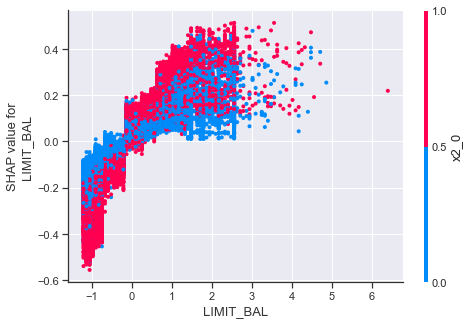

In [207]:
shap.dependence_plot("LIMIT_BAL", lgbm_shap_values[0], X_train_enc)

We can see as `LIMIT_BAL` increases, SHAP values for class 0 increase as well which means class is likely to be 0 (non default) with higher values for LIMIT_BAL. Also, we can see `LIMIT_BAL` is interacted with x2_0 a lot.

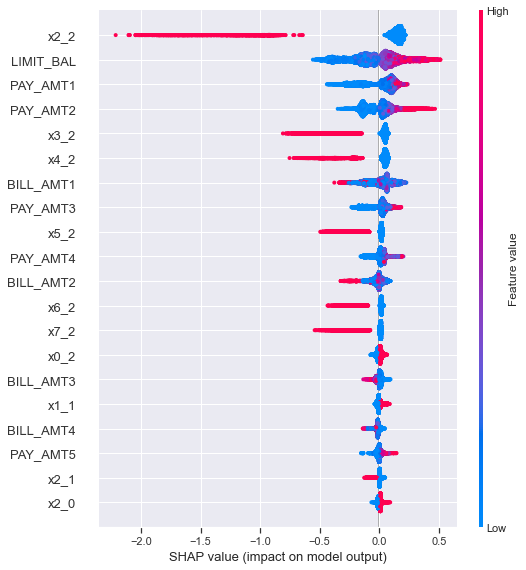

In [205]:
shap.summary_plot(lgbm_shap_values[0], X_train_enc)

Based on the summary plot above, we observe that payment delay for two months is the most important indicator of non-default, then `LIMIT_BAL`, `PAY_AMT1`, `PAY_AMT2` are also very important to predict non-default class.

Let's take an example of one feature in summary plot, `x2_2`. We can see lower value of x2_2 corresponds to higher SHAP value which means if the client does not have any delay payments for 2 months in September, it is most likely to predict non-default class which makes sense.

`EDUCATION` and `SEX` seems not influence the prediction much because they are not showing at the lower part of the plot. This might be there are a lot of unknown data in the dataset.

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={accuracy:2,viz:2,reasoning:4}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

In [208]:
print(classification_report(y_test, best_lgbm.predict(X_test), target_names=["not-default", "default"]))

              precision    recall  f1-score   support

 not-default       0.87      0.85      0.86      4696
     default       0.51      0.56      0.54      1304

    accuracy                           0.79      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000



Yes. The test macro-f1 is 70% which is consistent with the validation macro-f1.

The model didn't suffer optimization bias because the hyperparameter of the best model gave similar performance on test set which means the model generalizes well.

In [210]:
best_lgbm.fit(X_train, y_train)
X_test_enc = pd.DataFrame(
    data = preprocessor.transform(X_test),
    columns = feature_names,
    index = X_test.index
)
X_test_enc

,PAY_AMT1,AGE,PAY_AMT6,PAY_AMT2,PAY_AMT5,BILL_AMT3,PAY_AMT4,BILL_AMT4,LIMIT_BAL,BILL_AMT1,...,x7_-2,x7_-1,x7_0,x7_2,x7_3,x7_4,x7_5,x7_6,x7_7,x7_8
25665,-0.259964,-1.029426,0.259165,-0.230030,-0.270520,-0.484529,1.161420,-0.671954,-0.982987,-0.300983,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16464,-0.145865,2.550825,-0.179543,-0.178220,-0.190331,0.090264,-0.208476,0.115932,-0.675548,0.335277,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22386,0.068249,-0.595456,-0.234752,0.027617,0.045514,1.663729,0.543219,1.768395,0.016191,1.429288,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10149,-0.293263,0.597961,-0.289632,-0.276875,-0.315106,-0.682087,-0.314202,-0.671954,0.246770,-0.374887,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8729,-0.269512,0.814945,-0.271522,-0.223004,-0.291764,-0.550711,-0.291712,-0.529090,-0.906127,-0.584234,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9940,-0.258115,1.682885,-0.289632,-0.161028,-0.315106,-0.643985,-0.149314,-0.633904,-0.060669,-0.677401,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11351,-0.244807,1.899870,-0.255497,-0.217710,-0.275765,-0.452760,-0.274893,-0.422618,-0.752408,-0.504618,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29732,-0.337542,1.031930,-0.226520,-0.074880,-0.263963,-0.535923,-0.314202,-0.574899,-1.213567,-0.610041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9088,-0.202318,1.574393,-0.289632,-0.276875,-0.203641,-0.682087,-0.131572,-0.619300,-0.906127,-0.072224,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
lgbm = best_lgbm.named_steps["lgbmclassifier"]
lgbm.fit(X_test_enc, y_test)
explainer = shap.TreeExplainer(lgbm)
test_shap_values = explainer.shap_values(X_test_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


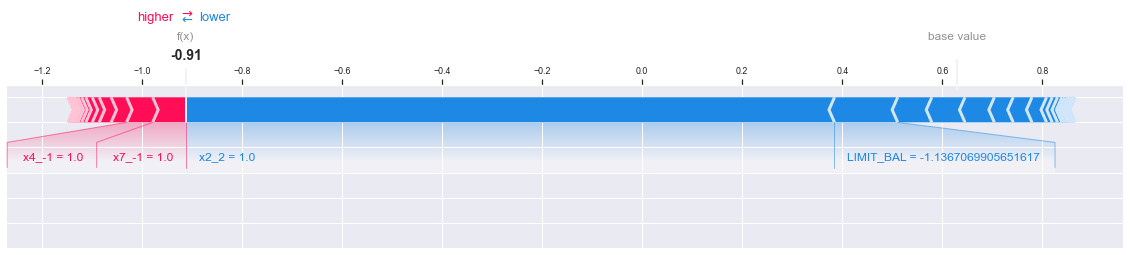

In [214]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    test_shap_values[0][11, :],
    X_test_enc.iloc[11, :],
    matplotlib=True,
)

In [215]:
lgbm.predict_proba(X_test_enc)[11]

array([0.28668946, 0.71331054])

In [216]:
lgbm.predict(X_test_enc)[11]

1

We can see the forces that drive the prediction. Features that push the prediction to a higher value are shown in red while features that push the prediction to a lower value are shown in blue. In this particular case, the base prediction is around 0.62 and the predicted value is -0.91. Because our base class is 0, we'll predict the positive class which is default.

The example has much more evidence for class 1 and some example features pushing the prediction towards class 1 are: positive `x2_2` which is payment delay for 2 months and smaller`LIMIT_BAL` which is the credit limit. Features which are pushing the prediction towards class 0 are `x4_-1` and `x7_-1` which means paid in full in August and July. This makes sense because people who pay the money in full for credit card are less likely to be classified as default.

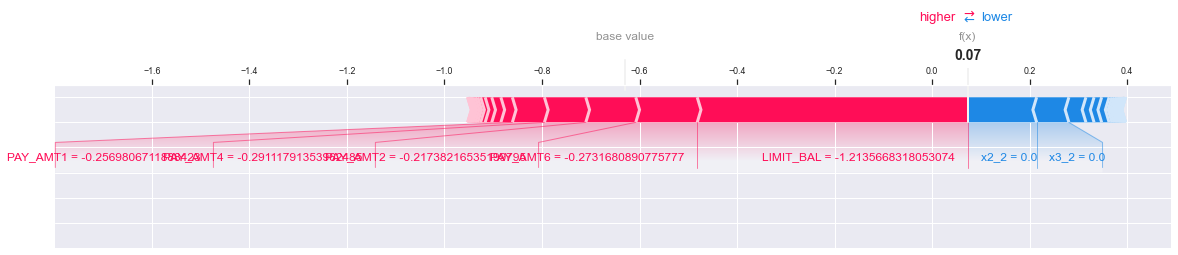

In [218]:
shap.force_plot(
    explainer.expected_value[1],
    test_shap_values[1][12, :],
    X_test_enc.iloc[12, :],
    matplotlib=True,
)

In [220]:
lgbm.predict_proba(X_test_enc)[12]

array([0.48157393, 0.51842607])

In [219]:
lgbm.predict(X_test_enc)[12]

1

The base class now is 1 and in this particular case, the base prediction is around -0.62 and the predicted value is 0.07. Therefore, we will predict 1 which is default for this example.

The example has much more evidence for class 1 and some example features pushing the prediction towards class 1 is `LIMIT_BAL` which is the credit limit. Features which are pushing the prediction towards class 0 are smaller `x2_2` and smaller `x3_2` which means they don't have delay payment for 2 months. This also makes sense.

## 13. Summary of results <a name="13"></a>
<hr>

|   |   |   |   |   |
|---|---|---|---|---|
| EDA  | `PAY_*`, pay status, `LIMIT_BAL`, credit limit are likely to be a strong predictor. The columns about monthly pay status, monthly bill amounts and history of past payments are highly correlated with each other which means potential co-linearity problem.|
| Feature Engineering  | The new features `PAY_PROPORTION_*`(proportion of money owed to bank over credit limit) and `POTENTIAL_RISK`(whether the person is under 35 and with high credit limit) did not improve the validation score. |
| Baseline  | Dummy model with `strategy=stratified` gives 50.2% validation macro-f1 |
| Linear model(Logistic Regression) | Logistic regression gives 69.2% validation macro-f1 |
| Class imbalance(`class_weight` vs `smote`) | `SMOTE` (validation f1: 68.9%) performs worse than `class_weight` (validation macro-f1: 69.2%) on Logistic Regression. Therefore, we choose `class_weight=balanced` since it fits with less time |
| Logistic Regression Hyperparameter Tunning | Logistic regression gives 69.2% validation macro-f1 with `RamdomizedSearch`. Therefore, based on Oscam's Razor principle, we choose the simple model with default C = 1.0 |
| Model Selection | Options: basic classifier: `Naive Bayes`, Ensemble(tree-based): `Random Forest`, `LightGBM`, `XGBoost` and `Stacking`, `LightGBM` gave higher macro-f1, 68.5% which is a little bit lower than `Logistic Regression`. `Random Forest` might be overfitting. But considering interpretability, both `Logistic Regression` and `LightGBM` are strong candidate models|
| Feature Selection   | Applied L1 regularization for feature selection, we do not get improvement at all |
| Hyperparameter Optimization   | Hyperparametr Tunning on `Random Forest` reached 70.4% validation macro-f1(less overfitting) and `LightGBM` reached 70.6% validation macro-f1 |
| Interpretation   | Based on `LGBM`, `PAY_*`, the pay status column has stronger association with target compared to other explanatory variables. Following is `LIMIT_BAL`, credit limit |
| Test Report   | Reached 70% macro-f1 on test set and the result is consistent with validation score. We can trust our model |


**Some comments:**

The biggest takeaway is the data science project pipeline has similarities, but each step has a lot of difference. We are not just training exhaustively for every classification model and trying every possibilities. There should be consideration on either the time, the resource, the need and the interpretability. 

Also, sometimes, easier model will perform better. Studying the dataset and problem itself is more important than trying every possible models on the dataset. Data science is a subject of making choices, and its wisdom is about making choices.